In [2]:
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import copy
import pkg_resources
from numpy import ndarray
from numpy.typing import NDArray
from dataclasses import dataclass
from typing import Callable, List, Optional


In [3]:
from trachoma.trachoma_functions import *
import multiprocessing
from joblib import Parallel, delayed
import pkg_resources
num_cores = multiprocessing.cpu_count()

#############################################################################################################################
#############################################################################################################################

# initialize parameters, sim_params, and demography

params = {'N': 3000,
          'av_I_duration' : 2,
          'av_ID_duration':200/7,
          'inf_red':0.45,
          'min_ID':11, #Parameters relating to duration of infection period, including ID period
          'av_D_duration':300/7,
          'min_D':1, #Parameters relating to duration of disease period
          'v_1':1,
          'v_2':2.6,
          'phi':1.4,
          'epsilon':0.5,#Parameters relating to lambda function- calculating force of infection
          #Parameters relating to MDA
          'MDA_Cov':0.8,
          'MDA_Eff': 0.85, # Efficacy of treatment
          'rho':0.3,
          'nweeks_year':52,
          'babiesMaxAge':0.5, #Note this is years, need to check it converts to weeks later
          'youngChildMaxAge':9,#Note this is years, need to check it converts to weeks later
          'olderChildMaxAge':15, #Note this is years, need to check it converts to weeks later
          'b1':1,#this relates to bacterial load function
          'ep2':0.114,
          'n_inf_sev':38,
          'TestSensitivity': 0.96,
          'TestSpecificity': 0.965,
          'SecularTrendIndicator': 0,
          'SecularTrendYearlyBetaDecrease': 0.01,
          'vacc_prob_block_transmission':  0.6, 
          'vacc_reduce_bacterial_load': 0.8, 
          'vacc_reduce_duration': 0,
          'vacc_coverage': 0,  
          'vacc_waning_length': 52 * 5}


burnin = 100*52
timesim = burnin + 21*52

sim_params = {'timesim': timesim, 
              'burnin': burnin,
              'N_MDA':5, # irrelevant due to input method
              'n_sim':20}


demog = {'tau': 0.0004807692, 
         'max_age': 3120,
         'mean_age': 1040}



previous_rounds = 0


Start_date = date(2010,1, 1)
End_date = date(2030,12,31)


## Modifying Matt's updated run folder to include the version of sim_Ind_MDA which includes vaccination. Need to update/match inputs for SimulationFunction.

In [4]:
def seed_to_state(seed):
    np.random.seed(seed)
    return np.random.get_state()

outputYear = range(2019, 2041) # CHECK this, was 2019 to 2041
outputTimes = getOutputTimes(outputYear)
outputTimes = get_Intervention_times(outputTimes, Start_date, sim_params['burnin'])

# this is essentially the same as the original version of the Trachoma_Simulation function

def SimulationFunction(params, sim_params, demog, MDA_times, MDAData, vacc_times, VaccData, seed_bump, beta):

    # Longitudinal simulations:

    # Setting beta; the higher this is the higher the prevalence. 0.12 has prevalence around 20%
    #bet = np.random.uniform(size=sim_params['n_sim'], low=0.1, high=0.12)
    bet = np.ones(sim_params['n_sim']) * beta
    # Run multiple simulations
    def multiple_simulations(i):
        seed = i * seed_bump

        # Generate some random numbers
        np.random.seed(seed)
# we generate a numpy state for each simulation by saving a state. If the seed is set above, this will be consistent from run to run
        numpy_states = list(map(lambda s: seed_to_state(s), np.random.randint(2^32, size=1)))
        vals = Set_inits(params=params, demog=demog, sim_params = sim_params, MDAData=MDAData, numpy_state = numpy_states[0])    # Set initial conditions
        vals = Seed_infection(params=params, vals=vals) # Seed infection
        
        # vals = Check_and_init_MDA_and_survey_counts(vals, numpy_states[0])
        
        vals = Check_and_init_vaccination_state(params,vals)
        
        vals = Check_and_init_MDA_treatment_state(params, vals, MDAData, numpy_state=numpy_states[0])
        
        out, results = sim_Ind_MDA_Include_Survey(params, vals, timesim, burnin, demog, bet[i], MDA_times, MDAData, vacc_times, VaccData, outputTimes, doSurvey = False, doIHMEOutput = False, numpy_state = numpy_states[0])
        return out

    data_store_all_sim = Parallel(n_jobs=num_cores)(delayed(multiple_simulations)(i) for i in range(sim_params['n_sim']))

    return data_store_all_sim




# analyse the runs of the simulations
# we return some aggregated results along with the raw data
def analyseResults(data, sim_params):

    True_Prev_Infection_children_1_9 = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    True_Prev_Disease_children_1_9 = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    #True_Prev_Disease = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    #True_Prev_Infection = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    Time = np.arange(sim_params['timesim'] )

    
    for i in range(sim_params['n_sim']):

        #True_Prev_Disease[:, i] = data[i]['True_Prev_Disease'][0: sim_params['timesim']]
        #True_Prev_Infection[:, i] = data[i]['True_Prev_Infection'][0: sim_params['timesim']]
        True_Prev_Infection_children_1_9[:, i] = data[i]['True_Prev_Infection_children_1_9'][0: sim_params['timesim']]
        True_Prev_Disease_children_1_9[:, i] = data[i]['True_Prev_Disease_children_1_9'][0: sim_params['timesim']]

    
    results = pd.DataFrame({'Time': Time / 52,
                            'Mean_Disease_Children': np.mean(True_Prev_Disease_children_1_9, axis=1),
                            'Mean_Infection_Children': np.mean(True_Prev_Infection_children_1_9, axis=1),
                            #'Mean_Disease_All': np.mean(True_Prev_Disease, axis=1),
                            #'Mean_Infection_All': np.mean(True_Prev_Infection, axis=1),
                            'Median_Disease_Children': np.median(True_Prev_Disease_children_1_9, axis=1),
                            'Median_Infection_Children': np.median(True_Prev_Infection_children_1_9, axis=1),
                            #'Median_Disease_All': np.median(True_Prev_Disease, axis=1),
                            #'Median_Infection_All': np.median(True_Prev_Infection, axis=1)
                            })

    return results,True_Prev_Infection_children_1_9, True_Prev_Disease_children_1_9 #, True_Prev_Disease, True_Prev_Infection, 




# function to get the MDA data for the specified coverage file
def get_MDA_data(coverageFileName):
    MDAData = readPlatformData(coverageFileName, "MDA")
    MDA_dates = getInterventionDates(MDAData)
    MDA_times = get_Intervention_times(MDA_dates, Start_date, sim_params['burnin'])
    return MDAData, MDA_times

# function to get the vaccination data for the specified coverage file
def get_vacc_data(coverageFileName):
    VaccData = readPlatformData(coverageFileName, "Vaccine")
    vacc_dates = getInterventionDates(VaccData)
    vacc_times = get_Intervention_times(vacc_dates, Start_date, sim_params['burnin'])
    return VaccData, vacc_times

In [5]:

seed = 100
beta = 0.17


## The runs! Matt's scenarios are first and then I explore vaccination schemes using xlsx/csv files.

## This lets us answer questions regarding age-based allocation, and explore factors such as timings and coverage.

## Some questions would require changing the code e.g. prioritising based on the number of previous treatments. Other questions straight-up require research, such as vaccine efficacy and waning rate.

### Matt's scenarios

#### Scenario M1: No interruption

In [6]:
MDAData, MDA_times = get_MDA_data("scen1_no_interruption.csv")
VaccData, vacc_times = get_vacc_data("scen1_no_interruption.csv")
data_no_interruption = SimulationFunction(params, sim_params, demog, MDA_times, MDAData, vacc_times, VaccData, seed_bump = seed, beta = beta)
res_no_interruption = analyseResults(data_no_interruption, sim_params)

#### Scenario M2: Interruption w/out mitigation

In [7]:
MDAData, MDA_times = get_MDA_data("scen1_interrupt_no_mitigation.csv")
VaccData, vacc_times = get_vacc_data("scen1_interrupt_no_mitigation.csv")
data_interrupt_no_mitigation = SimulationFunction(params, sim_params, demog, MDA_times, MDAData, vacc_times, VaccData, seed_bump = seed, beta = beta)
res_interrupt_no_mitigation = analyseResults(data_interrupt_no_mitigation, sim_params)

#### Scenario M3: Interruption w/ mitigation

In [8]:
MDAData, MDA_times = get_MDA_data("scen1_interrupt_mitigation.csv")
VaccData, vacc_times = get_vacc_data("scen1_interrupt_mitigation.csv")
data_interrupt_mitigation = SimulationFunction(params, sim_params, demog, MDA_times, MDAData, vacc_times, VaccData, seed_bump = seed, beta = beta)
res_interrupt_mitigation = analyseResults(data_interrupt_mitigation, sim_params)

Text(0.5, 1.0, 'Prevalence of disease in children 1-9')

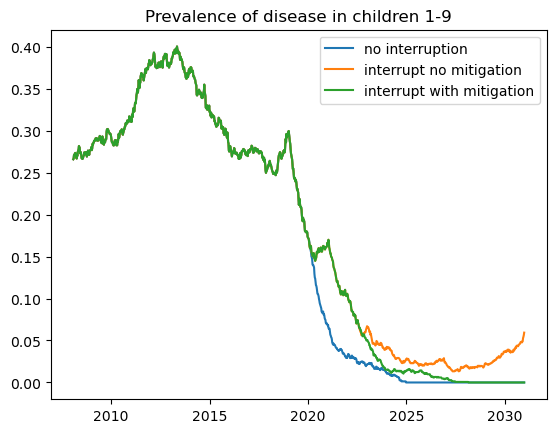

In [9]:
import matplotlib.pyplot as plt
start_year = 2010-burnin/52 # was 2018 - check to match csv dates
plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_no_interruption[0]['Median_Disease_Children'][(sim_params['burnin']-100): sim_params['timesim']]))
plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_interrupt_no_mitigation[0]['Median_Disease_Children'][(sim_params['burnin']-100): sim_params['timesim']]))
plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_interrupt_mitigation[0]['Median_Disease_Children'][(sim_params['burnin']-100): sim_params['timesim']]))
plt.legend(['no interruption', 'interrupt no mitigation', 'interrupt with mitigation']) 
plt.title("Prevalence of disease in children 1-9")

Text(0.5, 1.0, 'Prevalence of infection in children 1-9')

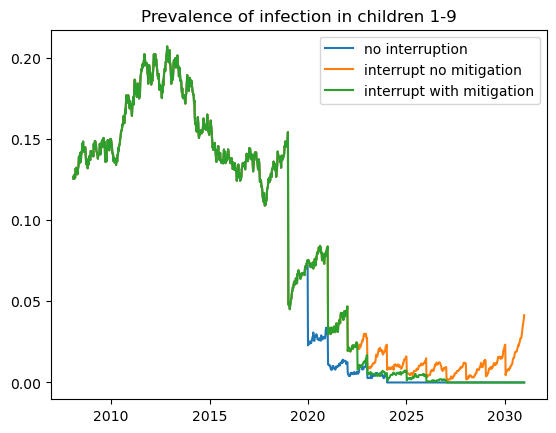

In [10]:


plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]), np.array(res_no_interruption[0]['Median_Infection_Children'][(sim_params['burnin']-100): sim_params['timesim']]))
plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]), np.array(res_interrupt_no_mitigation[0]['Median_Infection_Children'][(sim_params['burnin']-100): sim_params['timesim']]))
plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]), np.array(res_interrupt_mitigation[0]['Median_Infection_Children'][(sim_params['burnin']-100): sim_params['timesim']]))
plt.legend(['no interruption', 'interrupt no mitigation', 'interrupt with mitigation']) 
plt.title("Prevalence of infection in children 1-9")

## Export

In [11]:
scenM1 = res_no_interruption[0]['Median_Infection_Children']
scenM2 = res_interrupt_no_mitigation[0]['Median_Infection_Children']
scenM3 = res_interrupt_mitigation[0]['Median_Infection_Children']

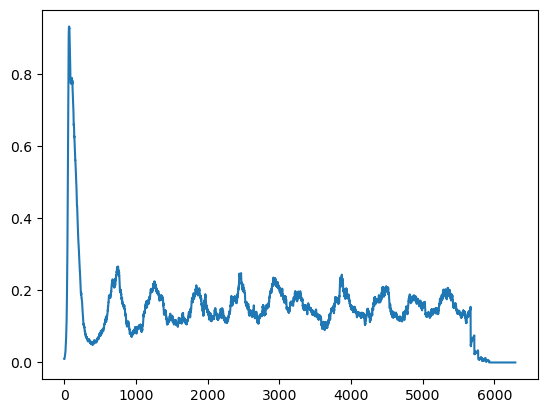

In [12]:
plt.plot([i for i in range(len(scenM1))], scenM1)

In [13]:
import pandas as pd
exportmatt = pd.DataFrame({'scenM1': scenM1,
                          'scenM2': scenM2,
                          'scenM3': scenM3})

In [14]:
#exportmatt.to_csv('matt.csv', index=True)